# GPA, Major, and Unemployment Analysis

## Table of Contents:
[Data ingestion and cleaning](#Data-ingestion-and-cleaning)\
[Engineer datasets](#Engineer-datasets)\
[Analysis](#Analysis)
* [Most Popular Majors Between 1993 and 2015](#Most-Popular-Majors-Between-1993-and-2015)
* [GPA vs. Salary Over Time](#GPA-vs.-Salary-Over-Time)


[Conclusion](#Conclusion)

In [1]:
from matplotlib import pyplot as plt 
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
from pandasql import sqldf
import seaborn as sns
sns.set_theme()

## Data ingestion and cleaning

In [2]:
# https://think.cs.vt.edu/corgis/csv/graduates/
# Every year, graduate majors and salary
graduates_import = pd.read_csv("edu_data/graduates.csv")
print('graduates data n_rows x n_columns:', graduates_import.shape)

# https://think.cs.vt.edu/corgis/csv/school_scores/
# Every year, SAT scores
gpa_import = pd.read_csv("edu_data/school_scores.csv")
print('gpa data n_rows x n_columns:', gpa_import.shape)

graduates data n_rows x n_columns: (517, 50)
gpa data n_rows x n_columns: (577, 99)


In [3]:
# null handling
# there are no nulls in either datasets, else use df.fillna()

In [4]:
# import select columns from gpa dataset
gpa = gpa_import[["Year", 
                  "State.Code", 
                  "Total.Test-takers", 
                  "Academic Subjects.English.Average GPA",
                  "Academic Subjects.Foreign Languages.Average GPA", 
                  "Academic Subjects.Natural Sciences.Average GPA", 
                  "Academic Subjects.Social Sciences/History.Average GPA"]].copy()

# replace dots with underscores
gpa_rename = {
                  "State.Code":"State_Code",
                  "Total.Test-takers":"Total_Testers", 
                  "Academic Subjects.English.Average GPA":"Eng_AVG_GPA", 
                  "Academic Subjects.Foreign Languages.Average GPA":"ForLan_AVG_GPA", 
                  "Academic Subjects.Natural Sciences.Average GPA":"Sci_AVG_GPA", 
                  "Academic Subjects.Social Sciences/History.Average GPA":"SS_AVG_GPA"
}

gpa.rename(columns = gpa_rename, inplace = True)
gpa.head()

,Year,State_Code,Total_Testers,Eng_AVG_GPA,ForLan_AVG_GPA,Sci_AVG_GPA,SS_AVG_GPA
0,2005,AL,3985,3.53,3.54,3.52,3.59
1,2005,AK,3996,3.35,3.34,3.25,3.39
2,2005,AZ,18184,3.45,3.41,3.43,3.55
3,2005,AR,1600,3.61,3.64,3.55,3.67
4,2005,CA,186552,3.32,3.29,3.20,3.38


In [5]:
# import select columns from graduates dataset
graduates = graduates_import[["Year", 
                              "Demographics.Total", 
                              "Education.Major", 
                              "Salaries.Median", 
                              "Salaries.Mean",
                              "Employment.Status.Unemployed"
                             ]].copy()

# replace dots with underscores
graduates_rename = {
                  "Demographics.Total":"Demographics_Year",
                  "Education.Major":"Education_Major", 
                  "Salaries.Median":"Salaries_Median",
                  "Salaries.Mean":"Salaries_Mean",
                  "Employment.Status.Unemployed":"Unemployed"
}

graduates.rename(columns = graduates_rename, inplace = True)
graduates.head()

,Year,Demographics_Year,Education_Major,Salaries_Median,Salaries_Mean,Unemployed
0,1993,1295598,Biological Sciences,51000.0,160585.73,22803
1,1993,211875,Chemical Engineering,56000.0,126176.52,3647
2,1993,507616,Chemistry,60000.0,148872.00,11437
3,1993,336366,Civil Engineering,50000.0,129070.55,8163
4,1993,1070111,Computer Science and Math,49000.0,134299.53,28925


## Engineer datasets

In [6]:
# group by to generate dataset on 
# graduates, unemployment, and salaries by year
graduates["Demographics_Year"] = graduates["Demographics_Year"].astype("float")
graduates["Unemployed"] = graduates["Unemployed"].astype("float")

query = """
SELECT 
    Year,
    SUM(Unemployed) AS Unemployed_Total,
    SUM(Demographics_Year) AS Demographics_Total,
    SUM(Salaries_Mean * Demographics_Year)/SUM(Demographics_Year) AS Salaries_Mean,
    SUM(Salaries_Median * Demographics_Year)/SUM(Demographics_Year) AS Salaries_Median,
    SUM(Unemployed)/SUM(Demographics_Year) AS Unemployed_Percentage
FROM graduates
GROUP BY Year
"""

graduates_annual = sqldf(query)
graduates_annual.head()

,Year,Unemployed_Total,Demographics_Total,Salaries_Mean,Salaries_Median,Unemployed_Percentage
0,1993,211381.0,7714187.0,161795.168848,51517.264360,0.027402
1,1995,163899.0,7974877.0,51764.499828,47429.573522,0.020552
2,1997,127293.0,8307491.0,56738.339946,51735.331883,0.015323
3,1999,126525.0,8628286.0,61147.557206,56242.343149,0.014664
4,2001,22968.0,625286.0,37211.882257,36234.587053,0.036732


In [7]:
# group by to generate dataset on 
# gpa across subjects by year
query = """
SELECT Year, 
    SUM(Total_Testers) AS Total_Testers,
    SUM(Eng_AVG_GPA * Total_Testers)/SUM(Total_Testers) AS Eng_AVG_GPA,
    SUM(ForLan_AVG_GPA * Total_Testers)/SUM(Total_Testers) AS ForLan_AVG_GPA,
    SUM(Sci_AVG_GPA * Total_Testers)/SUM(Total_Testers) AS Sci_AVG_GPA,
    SUM(SS_AVG_GPA * Total_Testers)/SUM(Total_Testers) AS SS_AVG_GPA
FROM gpa
GROUP BY Year
"""

gpa_annual = sqldf(query)
gpa_annual.head()

,Year,Total_Testers,Eng_AVG_GPA,ForLan_AVG_GPA,Sci_AVG_GPA,SS_AVG_GPA
0,2005,1344824,3.309681,3.268411,3.230020,3.371597
1,2006,1339734,3.334387,3.298702,3.248825,3.394448
2,2007,1418845,3.334498,3.294552,3.248360,3.392467
3,2008,1443779,3.337708,3.281492,3.232848,3.373885
4,2009,1443858,3.373534,3.311573,3.249317,3.384326


In [8]:
# join graduates and gpa datasets
query = """
SELECT R.*, P.*
FROM graduates_annual R
    INNER JOIN gpa_annual P ON R.Year = P.Year
"""

graduates_gpa = sqldf(query)
graduates_gpa.head()

,Year,Unemployed_Total,Demographics_Total,Salaries_Mean,Salaries_Median,Unemployed_Percentage,Total_Testers,Eng_AVG_GPA,ForLan_AVG_GPA,Sci_AVG_GPA,SS_AVG_GPA
0,2006,49346.0,1325854.0,38354.381924,37317.756706,0.037218,1339734,3.334387,3.298702,3.248825,3.394448
1,2008,42591.0,941339.0,43601.050407,42394.150248,0.045245,1443779,3.337708,3.281492,3.232848,3.373885
2,2010,737201.0,17970466.0,72880.059501,67684.816215,0.041023,1419868,3.393655,3.330566,3.265382,3.397283
3,2013,712934.0,19499592.0,78408.260767,64796.576620,0.036561,1533175,3.424683,3.362295,3.300512,3.425051
4,2015,689259.0,21380924.0,83949.534313,70084.514243,0.032237,1552536,3.447424,3.408852,3.338899,3.449950


In [9]:
# nested query 
# rank majors by salary with 1 being the highest median salary
query = """
SELECT  Year,
        Salaries_Median,
        Education_Major,
        Salary_Rank_By_Major
FROM 
    (SELECT Year,
        Salaries_Median,
        Education_Major,
        RANK() OVER (PARTITION BY Year ORDER BY Salaries_Median DESC) AS Salary_Rank_By_Major
    FROM graduates)
WHERE Salary_Rank_By_Major = 1
"""

rank = sqldf(query)
rank

,Year,Salaries_Median,Education_Major,Salary_Rank_By_Major
0,1993,62000.0,Physics and Astronomy,1
1,1995,57000.0,Chemical Engineering,1
2,1995,57000.0,Chemistry,1
3,1997,63000.0,Electrical Engineering,1
4,1999,71000.0,Electrical Engineering,1
5,2001,55000.0,Electrical Engineering,1
6,2003,81000.0,Electrical Engineering,1
7,2006,54000.0,Chemical Engineering,1
8,2006,54000.0,Electrical Engineering,1
9,2008,68000.0,Electrical Engineering,1


In [10]:
# demographics percentage of different majors each year
# normalize the number of individuals in each major by annual population total
# to compute percentages
query = """
SELECT G.Year,
       G.Education_Major,
       G.Demographics_Year/A.Demographics_Total AS Demographics_Percentage
FROM graduates G
    INNER JOIN graduates_annual A ON G.Year = A.Year
"""

major_dem = sqldf(query)
major_dem

,Year,Education_Major,Demographics_Percentage
0,1993,Biological Sciences,0.167950
1,1993,Chemical Engineering,0.027466
2,1993,Chemistry,0.065803
3,1993,Civil Engineering,0.043604
4,1993,Computer Science and Math,0.138720
...,...,...,...
512,2015,Sociology,0.055027
513,2015,Statistics,0.002607
514,2015,"Zoology, General",0.007951
515,2015,Management & Administration,0.000000


In [11]:
# demographics representation of all majors between 1993 to 2015
query = """
SELECT Education_Major,
       AVG(Demographics_Percentage) AS Demographics_Percentage
FROM major_dem
GROUP BY Education_Major
ORDER BY AVG(Demographics_Percentage) DESC
LIMIT 10
"""

popular_majors = sqldf(query)
popular_majors.head()

,Education_Major,Demographics_Percentage
0,Psychology,0.186543
1,Biological Sciences,0.156365
2,Computer Science and Math,0.135992
3,Other Engineering,0.070582
4,Economics,0.068838


## Analysis

### Most Popular Majors Between 1993 and 2015

<font color = 'green'>
I generated a graph of the percentage distribution of the 10 most popular majors between 1993 and 2015. <br>
I observed that psychology is the most popular major, followed by biological sciences, and then computer science and math.
</font>

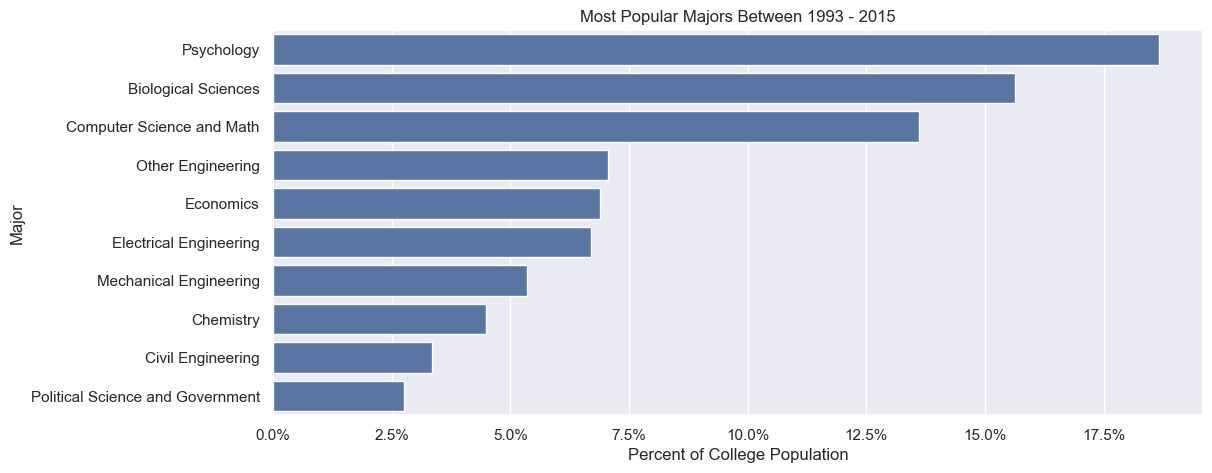

In [12]:
fig_pop, ax_pop = plt.subplots(figsize=(12,5))
ax_pop = sns.barplot(data = popular_majors, y = 'Education_Major', x = 'Demographics_Percentage')
ax_pop.xaxis.set_major_formatter(mtick.PercentFormatter(1.000))
ax_pop.set_title("Most Popular Majors Between 1993 - 2015")
ax_pop.set_ylabel('Major')
ax_pop.set_xlabel('Percent of College Population')
plt.show()

### GPA vs. Salary Over Time

<font color = 'green'>
I prepared and generated a new dataset by joining 2 data tables: graduates and gpa. <br>
</font>

In [13]:
#descriptive statistics
graduates_gpa.head()

,Year,Unemployed_Total,Demographics_Total,Salaries_Mean,Salaries_Median,Unemployed_Percentage,Total_Testers,Eng_AVG_GPA,ForLan_AVG_GPA,Sci_AVG_GPA,SS_AVG_GPA
0,2006,49346.0,1325854.0,38354.381924,37317.756706,0.037218,1339734,3.334387,3.298702,3.248825,3.394448
1,2008,42591.0,941339.0,43601.050407,42394.150248,0.045245,1443779,3.337708,3.281492,3.232848,3.373885
2,2010,737201.0,17970466.0,72880.059501,67684.816215,0.041023,1419868,3.393655,3.330566,3.265382,3.397283
3,2013,712934.0,19499592.0,78408.260767,64796.576620,0.036561,1533175,3.424683,3.362295,3.300512,3.425051
4,2015,689259.0,21380924.0,83949.534313,70084.514243,0.032237,1552536,3.447424,3.408852,3.338899,3.449950


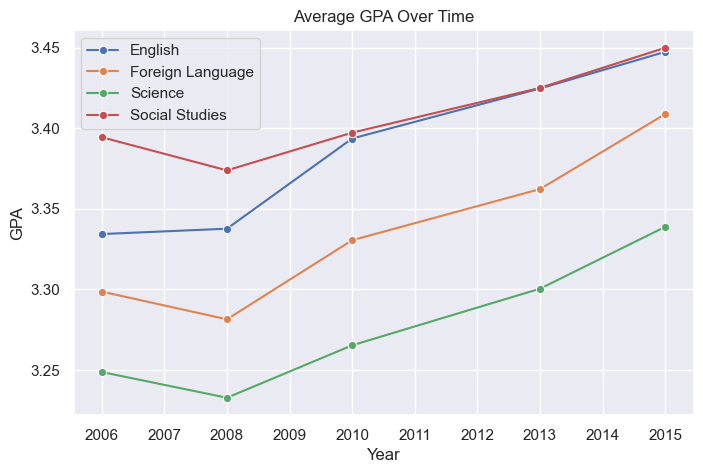

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.lineplot(data = graduates_gpa,
                  x = 'Year',
                  y = 'Eng_AVG_GPA',
                  marker = "o",
                  label = 'English')

ax = sns.lineplot(data = graduates_gpa,
                  x = 'Year',
                  y = 'ForLan_AVG_GPA',
                  marker = "o",
                  label = 'Foreign Language')

ax = sns.lineplot(data = graduates_gpa,
                  x = 'Year',
                  y = 'Sci_AVG_GPA',
                  marker = "o",
                  label = 'Science')

ax = sns.lineplot(data = graduates_gpa,
                  x = 'Year',
                  y = 'SS_AVG_GPA',
                  marker = "o",
                  label = 'Social Studies')

ax.set_title("Average GPA Over Time")
ax.set_ylabel('GPA')
ax.set_xlabel('Year')
ax.set_xticks(np.linspace(2006,2015,10))
plt.show()

<font color = 'green'>
I observed a dip in GPA in 2008. <br>
I hypothesized that this decrease in GPA might have resulted from the 2008 financial recession.
</font>

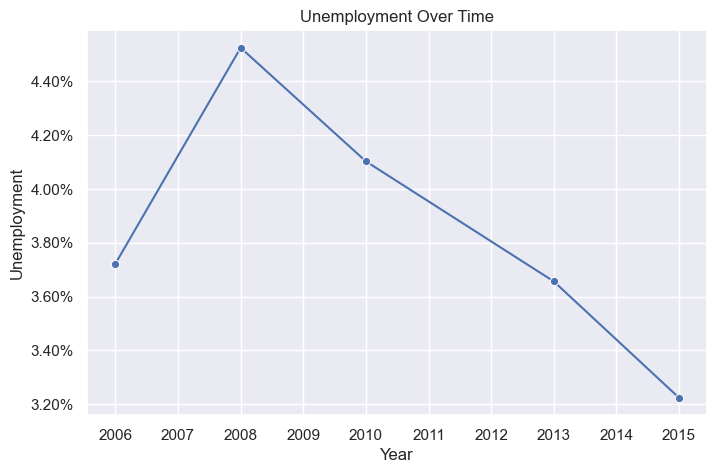

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.000))
ax = sns.lineplot(data = graduates_gpa,
                  x = 'Year',
                  y = 'Unemployed_Percentage',
                  marker = "o",
                  )

ax.set_title("Unemployment Over Time")
ax.set_ylabel('Unemployment')
ax.set_xlabel('Year')
ax.set_xticks(np.linspace(2006,2015,10))
plt.show()

## Conclusion

<font color = 'green'>
I observed a spike in unemployment rate in 2008 to 4.5%, which is noticeably higher before (3.7%) and after (4.1%). <br>
This supported my hypothesis that the decrease in GPA might have resulted from the 2008 financial recession. <br>
<br>
To further evaluate my hypothesis, I would analyze more data sets. <br>
For future investigations, I would investigate the possibility of a broader trend of a negative relationship between economic downturn and academic performance. <br>
If this trend exists, it would serve as justification for implementing protective measures in education during economic downturns.
</font>